<a href="https://colab.research.google.com/github/MehrabHamidi99/ReverseEngineeringNetworks/blob/master/ReverseEngineeringDLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.vmap

from sklearn.linear_model import LinearRegression, RANSACRegressor

import matplotlib.pyplot as plt
import time

In [2]:
from numpy.core.memmap import dtype
class MLP_ReLU(nn.Module):

  Bias_std = 1

  def __init__(self, n_in, layer_list):
    super(MLP_ReLU, self).__init__()

    self.input_dim = n_in

    self.first_layer = nn.Sequential(nn.Linear(n_in, layer_list[0]), nn.ReLU())

    self.hidden_layers = nn.Sequential()
    for i in range(1, len(layer_list)):
      self.hidden_layers.append(nn.Linear(layer_list[i - 1], layer_list[i]))
      if i != len(layer_list) - 1:
        self.hidden_layers.append(nn.ReLU())

    self.apply(self.init_weights)

    self.output_dim = layer_list[-1]

    # self.last_layer = nn.Sequential(nn.Linear(layer_list[-1], n_out), nn.ReLU())
  
  def forward(self, x):
    first_layer_result = self.first_layer(x)
    output = self.hidden_layers(first_layer_result)
    return output

  def initialize_weights(self, layer):
    # Using He-normal and standard normal to initialize weights and biases
    if 'linear' in str(layer.__class__).lower():
      nn.init.kaiming_normal_(layer.weight)
      layer.weight = nn.Parameter(torch.tensor(layer.weight, dtype=torch.float64))
      nn.init.normal_(layer.bias)
      layer.bias = nn.Parameter(torch.tensor(layer.bias, dtype=torch.float64))

  def init_weights(self, m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

  def get_all_parameters(self):

    weights = []
    biases = []
    for k, v in self.state_dict().items():
      if 'weight' in k:
        weights.append(v.T)
      if 'bias' in k:
        biases.append(v)

    return weights, biases

In [3]:
INPUT_DIM = 1

simple_network = MLP_ReLU(INPUT_DIM, [4, 1])

<ipython-input-2-9b8dfdca9923>:40: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [4]:
simple_network.output_dim

1

In [5]:
simple_network.get_all_parameters()

([tensor([[ 0.1819,  0.0137,  0.9721, -0.5668]]),
  tensor([[-0.5284],
          [ 1.0399],
          [-1.0233],
          [-0.1577]])],
 [tensor([0.0100, 0.0100, 0.0100, 0.0100]), tensor([0.0100])])

In [6]:
simple_network.modules

<bound method Module.modules of MLP_ReLU(
  (first_layer): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
  )
)>

In [7]:
class LinearRegion1D:

    def __init__(self, param_min, param_max, fn_weight, fn_bias, next_layer_off):

        # Region a^Tx + b = 0
        '''
        a: fn_weight
        b: bn_bias
        '''
        self._min = param_min
        self._max = param_max
        self._fn_weight = fn_weight
        self._fn_bias = fn_bias
        self._next_layer_off = next_layer_off

    def get_new_regions(self, new_weight_n, new_bias_n, n):
        weight_n = torch.dot(self._fn_weight, new_weight_n) # <a, a'>
        bias_n = torch.dot(self._fn_bias, new_weight_n) + new_bias_n # <b, a'> + b

        if weight_n == 0:
            min_image = bias_n
            max_image = bias_n
        elif weight_n >= 0:
            min_image = weight_n * self._min + bias_n
            max_image = weight_n * self._max + bias_n
        else:
            min_image = weight_n * self._max + bias_n
            max_image = weight_n * self._min + bias_n
        if 0 < min_image:
            return [self]
        elif 0 > max_image:
            self._next_layer_off.append(n)
            return [self]
        else:
            if weight_n == 0:
                return [self]
            else:
                preimage = (-bias_n) / weight_n
                next_layer_off0 = list(np.copy(self._next_layer_off))
                next_layer_off1 = list(np.copy(self._next_layer_off))
                if weight_n >= 0:
                    next_layer_off0.append(n)
                else:
                    next_layer_off1.append(n)
                region0 = LinearRegion1D(self._min, preimage, self._fn_weight, self._fn_bias, next_layer_off0)
                region1 = LinearRegion1D(preimage, self._max, self._fn_weight, self._fn_bias, next_layer_off1)
                return [region0, region1]

    def next_layer(self, new_weight, new_bias):
        # self._fn_weight = np.dot(self._fn_weight, new_weight.T).ravel()
        self._fn_weight = self._fn_weight @ new_weight
        self._fn_bias = self._fn_bias @ new_weight + new_bias
        self._fn_weight[self._next_layer_off] = 0
        self._fn_bias[self._next_layer_off] = 0
        self._next_layer_off = []

    @property
    def max(self):
        return self._max

    @property
    def min(self):
        return self._min

    @property
    def fn_weight(self):
        return self._fn_weight

    @property
    def fn_bias(self):
        return self._fn_bias

    @property
    def next_layer_off(self):
        return self._next_layer_off

    @property
    def dead(self):
        return np.all(np.equal(self._fn_weight, 0))


In [8]:
class MultipleLinearRegression():
    ''' Class that implements Multiple Linear Regression '''
    def __init__(self):
        self.b = 0
        self.w = []
        
    def fit(self, X, y):
        # If there is only one feature we need to reshape input.
        if len(X.shape) == 1:
            X.reshape(-1, 1)
            
        # Add 'ones' to model coefficient b in data.
        ones = np.ones(shape=X.shape[0]).reshape(-1, 1)
        X = np.concatenate((ones, X), 1)

        print(X.shape)


        print(X.transpose().dot(X).shape)
        print(np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).shape)
        print("----")
        coeficients = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
        self.b = coeficients[0]
        self.w = coeficients[1:]

    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self.b

            for xi, wi in zip(x, self.w):
                prediction += wi * xi
            
            predictions.append(prediction)
            
        return predictions

In [9]:

# Double increase the search distance through the line
# Starting from the origin

SAMPLE_RADIUS = int(10 * np.sqrt(INPUT_DIM)) # 10 * √d
SAMPLE_LENGTH = int(500 * np.sqrt(INPUT_DIM)) # 500 * √d

PRECISION_LINE = 1e-5
PRECISION_BOUNDARY = 1e-4

ITERATIONS = 15
EPS = 1e-3
CHECK_EPS = 5e-2
DEDUPLICATION_EPS = 1e-3

torch.random.seed = 32
np.random.seed = 32

APPROX_RADIUS = 0.2
APPROX_NUM = int(1.5 * INPUT_DIM)
APPROX_THRESHOLD = 0.9

MULTIPLE_POINTS = False  # Option for tuning approx_boundary, default is False.

CHECK_NUM = 10
CHECK_RADIUS = int(50 * np.sqrt(INPUT_DIM) * (1 / CHECK_EPS))

In [28]:
def plot_network_1d_1d(model, start_point=-10, step_size=.1):
  assert model.input_dim == 1
  samples = {}

  def sub_interval_solving(start, end):
      # print(start, end)
      start_point1 = model(torch.tensor([start], dtype=torch.float32)[None, :]).detach().numpy()
      start_point2 = model(torch.tensor([start + step_size], dtype=torch.float32)[None, :]).detach().numpy()
      start_slope = abs(float((start_point2 - start_point1) / step_size))

      if abs(start - end) < 1e-1:
        if round(start_slope, 4) not in samples:
          samples[round(start_slope, 4)] = [start, end]
        else:
          samples[round(start_slope, 4)][0] = min(samples[round(start_slope, 2)][0], start)
          samples[round(start_slope, 4)][1] = max(samples[round(start_slope, 2)][1], end)
        return

      end_point1 = model(torch.tensor([end], dtype=torch.float32)[None, :]).detach().numpy()
      end_point2 = model(torch.tensor([end + step_size], dtype=torch.float32)[None, :]).detach().numpy()
      end_slope = abs(float((end_point2 - end_point1) / step_size))

      # print(start_slope, end_slope)
      # input()


      if abs(end_slope - start_slope) < EPS:
        if round(start_slope, 2) not in samples:
          samples[round(start_slope, 2)] = [start, end]
        else:
          samples[round(start_slope, 2)][0] = min(samples[round(start_slope, 2)][0], start)
          samples[round(start_slope, 2)][1] = max(samples[round(start_slope, 2)][1], end)

        # print(samples)
      else:
        sub_interval_solving(start, (start + end) / 2)
        sub_interval_solving((start + end) / 2, end)

  sub_interval_solving(start_point, -1 * start_point)
  return samples

def plot_query(model, start_point=-10, end_point=10, step_size=.01):

  samples = {}
  samples_points = {}
  
  curent_point = start_point
  next_point = start_point + step_size
  curent_slope = 0
  while True:
    curent_y = float(model(torch.tensor([curent_point], dtype=torch.float32)[None, :]).detach().numpy())
    next_y = float(model(torch.tensor([curent_point + step_size], dtype=torch.float32)[None, :]).detach().numpy())

    slope = abs(float((next_y - curent_y) / (step_size)))
    if abs(slope - curent_slope) > EPS:
      curent_slope = slope

      samples[round(slope, 4)] = (curent_point, curent_y)
    else:
      if round(slope, 4) not in samples_points:
        samples_points[round(slope, 4)] = [(curent_point, curent_y)]
      elif len(samples_points[round(slope, 4)]) < 3:
        samples_points[round(slope, 4)].append((curent_point, curent_y))
    if curent_point > end_point:
      break
    curent_point += step_size
  return samples, samples_points

In [29]:
res, res_samp = plot_query(simple_network)
# for slope, pt in res.items():
#   y0 = float(simple_network(torch.tensor([pt[0]], dtype=torch.float32)[None, :]).detach().numpy())
#   y1 = float(simple_network(torch.tensor([pt[1]], dtype=torch.float32)[None, :]).detach().numpy())

#   # b = y0 - slope * pt[0]
#   # print(b)
#   # y1 = pt[1] * slope + b

#   print(pt)

#   plt.plot([pt[0], pt[1]], [y0, y1], 'bo', linestyle="--")

In [30]:
res

{0.0894: (-10, -0.8853471875190735),
 0.091: (-0.7400000000001694, -0.05771587789058685),
 0.1036: (-0.7300000000001694, -0.05680573731660843),
 0.0558: (-0.0600000000001689, 0.012605799362063408),
 0.0075: (-0.050000000000168895, 0.013163598254323006),
 0.0211: (-0.02000000000016889, 0.013387959450483322),
 0.9873: (-0.01000000000016889, 0.013177248649299145),
 1.0084: (0.009999999999831111, -0.0065684933215379715),
 1.0767: (0.01999999999983111, -0.016652032732963562)}

In [31]:
res_samp

{0.0894: [(-9.99, -0.8844534158706665),
  (-9.98, -0.8835596442222595),
  (-9.97, -0.8826659917831421)],
 0.1036: [(-0.7200000000001694, -0.05576974153518677),
  (-0.7100000000001694, -0.05473373830318451),
  (-0.7000000000001694, -0.053697749972343445)],
 0.0075: [(-0.040000000000168894, 0.013238385319709778),
  (-0.03000000000016889, 0.013313171453773975)],
 0.9873: [(-1.6888920817414999e-13, 0.0033043758012354374)],
 1.0767: [(0.029999999999831113, -0.027418674901127815),
  (0.039999999999831115, -0.03818532079458237),
  (0.04999999999983112, -0.04895196855068207)],
 1.0766: [(2.159999999999829, -2.320713758468628),
  (2.269999999999827, -2.4391467571258545),
  (2.6499999999998187, -2.8482792377471924)],
 1.0768: [(7.869999999999708, -8.468465805053711),
  (7.929999999999707, -8.533065795898438),
  (7.969999999999706, -8.576131820678711)],
 1.0765: [(7.939999999999706, -8.54383373260498),
  (8.019999999999705, -8.629966735839844),
  (8.139999999999702, -8.759166717529297)],
 1.0764:

[-10, -0.78125]
[-0.78125, -0.078125]
[-0.078125, 0.0]
[0.0, 0.078125]
[0.078125, 10]


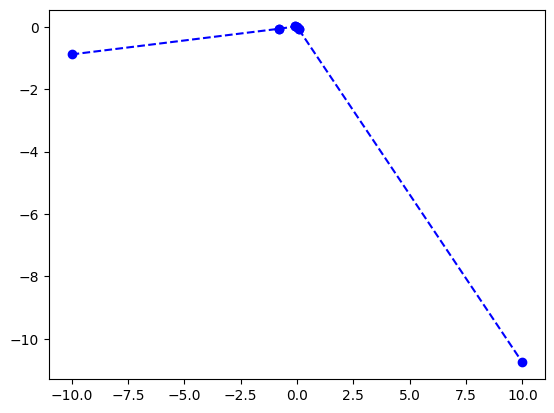

In [11]:
res = plot_network_1d_1d(simple_network)
for slope, pt in res.items():
  y0 = float(simple_network(torch.tensor([pt[0]], dtype=torch.float32)[None, :]).detach().numpy())
  y1 = float(simple_network(torch.tensor([pt[1]], dtype=torch.float32)[None, :]).detach().numpy())

  # b = y0 - slope * pt[0]
  # print(b)
  # y1 = pt[1] * slope + b

  print(pt)

  plt.plot([pt[0], pt[1]], [y0, y1], 'bo', linestyle="--")


In [12]:
res

{0.09: [-10, -0.78125],
 0.1: [-0.78125, -0.078125],
 0.29: [-0.078125, 0.0],
 1.06: [0.0, 0.078125],
 1.08: [0.078125, 10]}

In [13]:
simple_network.get_all_parameters()

([tensor([[ 0.1819,  0.0137,  0.9721, -0.5668]]),
  tensor([[-0.5284],
          [ 1.0399],
          [-1.0233],
          [-0.1577]])],
 [tensor([0.0100, 0.0100, 0.0100, 0.0100]), tensor([0.0100])])

In [ ]:

def plot_calc_1d(model, endpt1, endpt2, output_pts=False):
    assert len(endpt1) == 2, 'plot_calc_1d requires 2D input'
    points = np.array(calculate_exact_1d(model, torch.tensor(endpt1, dtype=torch.float64), torch.tensor(endpt2, dtype=torch.float64)))
    print(points)
    print(endpt1)
    print(endpt2)
    pts_x = (points * (endpt2[0].detach().numpy() - endpt1[0].detach().numpy())) + endpt1[0].detach().numpy()
    pts_y = (points * (endpt2[1].detach().numpy() - endpt1[1].detach().numpy())) + endpt1[1].detach().numpy()
    plt.scatter(pts_x, pts_y, color='black')
    if output_pts:
        return points

def plot_calc_2d(regions, ax, seed=33, edges=False, gradients=False, color_by_layer=True, colors=['blue', 'red', 'gold']):
    np.random.seed(seed)
    min_gradient = np.inf
    max_gradient = -np.inf
    for region in regions:
        gradient = region.fn_weight[0, 0]
        min_gradient = min(min_gradient, gradient)
        max_gradient = max(max_gradient, gradient)
    minimum = np.array([np.inf, np.inf])
    maximum = np.array([-np.inf, -np.inf])
    for region in regions:
        vertices = region.vertices
        minimum = np.minimum(np.min(vertices, axis=0), minimum)
        maximum = np.maximum(np.max(vertices, axis=0), maximum)
        if edges:
            edge_neurons = region.edge_neurons
            num_vertices = vertices.shape[0]
            for i in range(num_vertices):
                np.random.seed(hash(edge_neurons[i]) % (2**20) + seed)
                j = (i + 1) % num_vertices
                if vertices[i, 0] != vertices[j, 0] and vertices[i, 1] != vertices[j, 1]:
                    if color_by_layer:
                        _ = ax.plot([vertices[i, 0], vertices[j, 0]], [vertices[i, 1], vertices[j, 1]],
                                    c=colors[edge_neurons[i][0]])
                    else:
                        _ = ax.plot([vertices[i, 0], vertices[j, 0]], [vertices[i, 1], vertices[j, 1]],
                                    c=np.random.rand(3, 1))
                else:
                    _ = ax.plot([vertices[i, 0], vertices[j, 0]], [vertices[i, 1], vertices[j, 1]], c='black')
            if gradients:
                gradient = region.fn_weight[0, 0]
                gradient = (gradient - min_gradient) / (max_gradient - min_gradient)
                _ = ax.fill(vertices[:, 0], vertices[:, 1], c=np.array([0, gradient, 0]), alpha=0.9)
        else:
            _ = ax.fill(vertices[:, 0], vertices[:, 1], c=np.random.rand(3, 1))
    plt.xticks([], [])
    plt.yticks([], [])
    ax.set_xlim([minimum[0], maximum[0]])
    ax.set_ylim([minimum[1], maximum[1]])
    ax.set_aspect('equal')
    ax.set_xlabel('Input dim 1', size=30)
    ax.set_ylabel('Input dim 2', size=30)

<ipython-input-135-914ee21f60c7>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = np.array(calculate_exact_1d(model, torch.tensor(endpt1, dtype=torch.float64), torch.tensor(endpt2, dtype=torch.float64)))


[0.48284092 0.50292822 0.50562512 0.51190621 0.51408908 0.51625194
 0.53016988 0.57969476 0.60182832 0.68754443]
tensor([ 259.6422, -240.3001])
tensor([-277.8329,  219.0140])


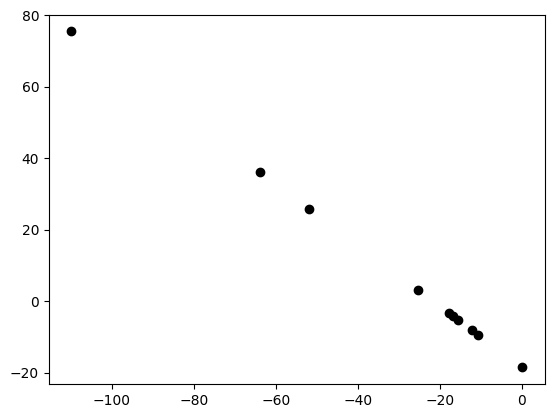

In [136]:
endpt1, endpt2 = sample_point()
plot_calc_1d(simple_network, endpt1, endpt2)
# exact_pts = calculate_exact_1d(simple_network, torch.tensor(endpt1, dtype=torch.float64), torch.tensor(endpt2, dtype=torch.float64))



In [ ]:
def compute_gradient_vmap(model, input_point, epsilon=1e-5):
    """
    Estimate the gradient of a black-box deep ReLU network using finite differences and vmap.
    
    :param model: The black-box PyTorch model (a callable function).
    :param input_point: The input point (NumPy array) at which to compute the gradient.
    :param epsilon: The perturbation value for finite differences.
    :return: The estimated gradient (NumPy array) at the input point.
    """

    # Convert the input_point to a PyTorch tensor
    x = torch.from_numpy(input_point).float()

    # Compute the function value f(X)
    f_x = model(x)

    # Create a perturbation matrix (each row is a perturbed input)
    perturbation_matrix = np.eye(input_point.size) * epsilon
    x_perturbed = torch.from_numpy(input_point + perturbation_matrix).float()

    # Compute the function values f(X_i) for all perturbed inputs
    # using vmap to batch the computation
    f_x_perturbed = torch.vmap(model)(x_perturbed)

    # Compute the finite difference approximation for the gradient
    grad = (f_x_perturbed - f_x) / epsilon

    return grad.numpy()

In [36]:
def sample_point():

  # Sample  midpoint at a certain radius
  midpoint = torch.rand((INPUT_DIM,)) - 0.5 * 10 # Sample a point from interval [-0.5, 0.5); M
  midpoint /= torch.linalg.norm(midpoint) # Make it a unit vector

  perp = torch.rand((INPUT_DIM,)) - 0.5 # v
  perp = perp - torch.dot(midpoint, perp) * midpoint # v - (v^T . M) * M      Why elementwise multiplication?!
  perp /= torch.linalg.norm(perp)

  endpt1 = SAMPLE_RADIUS * midpoint + (SAMPLE_LENGTH / 2) * perp # rM + lv
  endpt2 = SAMPLE_RADIUS * midpoint - (SAMPLE_LENGTH / 2) * perp # rM - lv

  return endpt1, endpt2


# def calculate_slope()


def single_binary_search(model, endpt1, endpt2, eps, precision=1e-5):

  y1 = model()


def approximate_critical_points(model, end_point1, end_point2, iterations_, eps, init_samples=1, precision=1e-5, use_outputs=None, single_search=False):
  """
  This function sample some points in the [0, 1] intnerval and query the network and calculate the slopes of the sorted queries and 
  keep the slopes which are distinct.
  Then do the binary search over the sampled points to find
  the correct hyperplane boundaries basesd on the queries (different slopes results from the model)

  There's two option single point and multiple point search, in multiple point we query the network a lot!

  INPUTS:
  model -> a pytorch model
  end_point1, end_point2 -> (1d torch tensor) line segment query
  iterations_ -> (int) number of iterations for the search queries
  eps -> (float) epsilon threshold for comaring the slopes
  init_samples -> (int) number of the samples to begin with
  precision -> (float) epsilon threshold for considering two query point distinct or not

  RETURN:
  (points belong to different hyperplane on the line segment, number of sampled pointss)
  """

  with torch.no_grad():

    end_point1 = end_point1.reshape(1, -1) # Making 2d array
    end_point2 = end_point2.reshape(1, -1)
    samples_t = torch.tensor(np.arange(0, 1.0000000001, 1./(init_samples + 1), dtype=np.float64), dtype=torch.float64) # sample points in [0, 1] with same division of the intnerval 
    total_samples = 0

    for iter in range(iterations_):
      num_samples = len(samples_t)
      samples = torch.repeat_interleave(end_point1, repeats=num_samples, dim=0) + (samples_t.reshape(-1, 1) * (end_point2 - end_point1)) # ep1 + t(ep1 - ep2) \forall t
      outcomes = model(samples) # get the query of the model

      total_samples += num_samples
      output_dim = outcomes.shape[1]

      if use_outputs == None:
          outputs_used = output_dim
      else:
          outputs_used = use_outputs

      # Calculating the slopes for all the output dim  of the hyperplanes: (f(x) - f(y)) / (x - y) for queries
##################### WHY do we need torch.abs ????????????!!!!!!!!!!!!
      # slopes = torch.abs(torch.divide(outcomes[1:,] - outcomes[:-1,],  torch.repeat_interleave((samples_t[1:] - samples_t[:-1])[:, None], repeats=model.output_dim, dim=1)))[:,:-1].T
      slopes = torch.abs(torch.divide(outcomes[1:,] - outcomes[:-1,],  torch.repeat_interleave((samples_t[1:] - samples_t[:-1])[:, None], repeats=model.output_dim, dim=1))).T

      # Check epsilon difference between calculated slopes
      diff = torch.logical_or(torch.less(slopes[:, 1:], (1 - eps) * slopes[:, :-1]), torch.greater(slopes[:, 1:], (1 + eps) * slopes[:, :-1]))
      diff = torch.any(diff, dim=0)

      if single_search:
        diff_indices = torch.nonzero(diff)[0] # signle search
      else:
        diff_indices = torch.nonzero(diff) # multiple search
      end_t = samples_t[[0, -1]]
      keep_t = samples_t[diff_indices + 1]

      # Sampling middle points
      if iter < iterations_ - 1:
        new_t_1 = (2 * keep_t + samples_t[diff_indices]) / 3
        new_t_2 = (2 * keep_t + samples_t[diff_indices + 2]) / 3
        if single_search:
          samples_t, _ = torch.sort(torch.hstack((end_t, keep_t, new_t_1, new_t_2))) # single search
        else:
          samples_t, _ = torch.sort((torch.vstack((end_t[:, None], keep_t, new_t_1, new_t_2))).flatten()) # multiple search

      # print(samples_t)


    # Compare the difference between sample vectors to the uniqueness threshold
    if len(samples_t) > 0:
      if single_search:
        unique = np.nonzero(samples_t[1:] - samples_t[:-1] > precision)[0] # single search
      else:
        unique = torch.nonzero(samples_t[1:] - samples_t[:-1] > precision).flatten() # multiple search
      output = 0.5 * (samples_t[torch.hstack((unique, torch.tensor([-1])))] + samples_t[torch.hstack((torch.tensor([0]), unique + 1))])
    else:
        output = samples_t

    return output, total_samples

def regions_1d(the_weights, the_biases, endpt1, endpt2):
    '''
    This function cosntruct all of the linear hyperplane of a network with its given weights and biases, over a line segment which is specified with
    the endpt1, endpt2

    INPUTS:
    the_weights -> (torch.tensor(2d))
    the biases -> (torch.tensor(3d))
    endpt1, endpt2 -> 2d tensors, line segment


    RETURN:
    [Regions]
    '''
    regions = [LinearRegion1D(param_min=0., param_max=1., fn_weight=(endpt2 - endpt1), fn_bias=endpt1,
                              next_layer_off=[])]
    depth = len(the_weights)

    for k in range(depth - 1):
        for n in range(the_biases[k].shape[0]):
            new_regions = []
            for region in regions:
                new_regions = new_regions + region.get_new_regions(the_weights[k][:, n], the_biases[k][n], n)
            regions = new_regions
        for region in regions:
            region.next_layer(the_weights[k], the_biases[k])
    for region in regions:
        region.next_layer(the_weights[-1], the_biases[-1])
    return regions


def region_pts_1d(regions, param_min=-torch.inf):
    '''
    This function return the points alogside the line segment for all the linear depth 1 linear regions of the network

    INPUTS:
    regions -> [Regions]

    RETURN:
    ([int], [int]), the x's length of the query line segment (endpoint1 - endpoint2) * x + endpoint1
    '''
    xs = []
    ys = []
    for region in regions:
        if region.min == param_min:
            pass
        else:
            xs.append(region.min)
            ys.append(region.min * region.fn_weight + region.fn_bias)
    return xs, ys


def calculate_exact_1d(model, end_point1, end_point2): #calc_1d
  '''
  This function calculate adn return exact boundary points of first depth alongside of the line segmennt

  INPUTS:
  model -> pytorch model
  endpoint1, endpoint2 -> torch.tensor, line segmeent

  RETURN:
  ([int]), exact boundary points of the netowkrs
  '''
  with torch.no_grad():
    the_weights, the_biases = model.get_all_parameters()
    # the_biases = model.first_layer.state_dict()['0.bias']

    # Construct all the linear regions, given weights and biases alongside a given line segment
    exact_regions = regions_1d(the_weights, the_biases, end_point1, end_point2)

    points, _ = region_pts_1d(exact_regions, 0)
    return points

def approx_boundary(model, point, radius, num_samples, threshold, iterations, eps, on_pos_side_of=None, init_samples=1, precision=1e-4, use_outputs=None, multiple_points = False):
  dim = model.input_dim
  results = []
  i = 0
  total_samples = 0

  while len(results) < num_samples:
    if len(results) == 0 and i > 10 * num_samples:  # Heuristic stopping point
        print("Exceeded maximum number of samples")
        return None, None, None, None, total_samples
    i += 1

    midpoint = torch.rand((dim,)) - 0.5 # Sample a point from interval [-0.5, 0.5); M
    midpoint /= torch.linalg.norm(midpoint) # Make it a unit vector

    perp = torch.rand((dim,)) - 0.5 # v
    perp = perp - torch.dot(midpoint, perp) * midpoint # v - (v^T . M) * M      Why elementwise multiplication?!
    perp /= torch.linalg.norm(perp)

    endpt1 = point + radius * midpoint + int(50 * np.sqrt(dim)) * perp
    endpt2 = point + radius * midpoint - int(50 * np.sqrt(dim)) * perp
    
    if type(on_pos_side_of) is not tuple:
      output, samples = approximate_critical_points(model, endpt1, endpt2, iterations, eps, init_samples=init_samples,
                                    precision=precision, use_outputs=use_outputs, single_search=False)
      total_samples += samples

      if len(output[1:-1]) > 0:
        output = output[1:-1]
        if len(results) == 0:
          results = torch.repeat_interleave(output[None, :], repeats=endpt2.shape[0], dim=0).T * torch.repeat_interleave((endpt2 - endpt1)[None, :], repeats=output.shape[0], dim=0) # appennding result length to investigate line inn between a * (x_1 - x_2) + x_1
        else:
          results = torch.cat([results, torch.repeat_interleave(output[None, :], repeats=endpt2.shape[0], dim=0).T * torch.repeat_interleave((endpt2 - endpt1)[None, :], repeats=output.shape[0], dim=0)], dim=0)
  
  X = results[:, :-1]
  y = results[:, -1]

  mlr = RANSACRegressor(random_state=0).fit(X, y)
  weight = torch.tensor(np.hstack((mlr.estimator_.coef_, -1)))

  bias = mlr.estimator_.intercept_

  bias /= torch.linalg.norm(weight)
  weight /= torch.linalg.norm(weight)

  return weight, bias, results[0, :], results, total_samples

def is_straight(model, point, vec, eps, use_outputs=None):
    '''
    This function get a point and a vector and investigate whether the moving alongside the vector starting from the given point
    change the hyperplane and we encounter bent or not

    INPUT:
      model -> a pytorch model
      point -> (1d torch tensor) starting point
      vec -> (1d torch tensor) vector which we want to move alonngside that
      eps -> (float) epsilon threshold for comaring the slopes
    
    RETRUN:
      torch(bool) -> indicate whether it's striaght or not
    '''
    # Moving from the point alongside the vic with 3 points
    samples = torch.cat([(point - vec)[None, :], point[None, :], (point + vec)[None, :]])
    preds = model(samples)
    num_outputs = preds.shape[1]

    if use_outputs == None:
        outputs_used = num_outputs
    else:
        outputs_used = use_outputs
    straight = True
    slopes1 = []
    slopes2 = []

    slopes1 = preds[1, :] - preds[0, :]
    slopes2 = preds[2, :] - preds[1, :]

    # Check whether the results point are in a stright line or not
    straight = torch.all(torch.logical_and(torch.abs(slopes2) > (1 - eps) * torch.abs(slopes1), torch.abs(slopes2) < (1 + eps) * torch.abs(slopes1)))
    return straight


def first_layer_estimate(model, approx_num1=0, approx_weight1=[], approx_bias1=[], unused=[]):


  approx_weight1 = []
  approx_bias1 = []
  approx_number_of_first_hidden_layer = 0
  s_time = time.time()
  layer1_samples = 0

  endpt1, endpt2 = sample_point()
  # Approximate region transition points along sample segment, and check against exact answer.
  approx_pts, samples = approximate_critical_points(model, endpt1, endpt2, ITERATIONS, EPS)

  layer1_samples += samples

  exact_pts = calculate_exact_1d(model, torch.tensor(endpt1, dtype=torch.float64), torch.tensor(endpt2, dtype=torch.float64))

  # Check the precision of the estimation  
  # for ex_pt in exact_pts:
  #   if torch.all(torch.abs(approx_pts - ex_pt) > 1e-5):
  #     print(ex_pt)
  #     print("ERORR")

  print("Estimated num pts along line: %d, true num pts: %d" % (len(approx_pts), len(exact_pts)))

  ##########

  for point_t in approx_pts:
    point = (endpt2 - endpt1) * point_t + endpt1

    # Check if this point lies on a hyperplane already found.
    repeated = False
    for m in range(approx_num1):
        if not repeated:
            value = np.dot(approx_weight1[m], point) + approx_bias1[m]
            value_threshold = CHECK_EPS * np.linalg.norm(point)
            if value_threshold > value > -value_threshold:
                repeated = True

    if not repeated: # and not (approx_num1 == network[0] and KNOWN_ARCHITECTURE):
      # Find the boundary in the neighborhood of each point by sampling more transition points.
      # and fitting a hyperplane.
      weight, bias, _, pts, samples = approx_boundary(model, point, APPROX_RADIUS, APPROX_NUM,
                                                      APPROX_THRESHOLD, ITERATIONS, EPS,
                                                      precision=PRECISION_BOUNDARY,
                                                      multiple_points=MULTIPLE_POINTS)
      layer1_samples += samples

      if np.array(weight).shape:  # Check that a valid hyperplane was found.
          valid = True
          i = 0
          extra_pts = []

          # Samples points a certain distance away to see if the hyperplane extends that far unchanged.
          while valid and i < CHECK_NUM:
              check_point = torch.rand((INPUT_DIM,)) - 0.5 # Sample a point from interval [-0.5, 0.5); M
              check_point = check_point - weight * np.dot(weight, check_point)
              check_point = point + CHECK_RADIUS * (check_point / torch.linalg.norm(check_point))
              check_vec = CHECK_RADIUS * CHECK_EPS * weight
              straight = is_straight(model, check_point, check_vec, EPS)
              layer1_samples += 3
              if straight:
                  valid = False
                  unused.append((point, weight, bias))
              i += 1


          # If passes checks, add candidate hyperplane to list for layer 1.
          if valid:
              # Check through proposed neurons for layer 1 for duplicate weights.
              duplicate = False
              # torch.norm(torch.abs(approx_weight1 - weight)) # TODODOOOOOOOOOOOOOOOOOOOOOO
              for n in range(0, approx_number_of_first_hidden_layer):
                  if np.linalg.norm(np.abs(approx_weight1[n]) - np.abs(weight)) < DEDUPLICATION_EPS:
                      duplicate = True
                      break
              if not duplicate:
                  approx_weight1.append(weight)
                  approx_bias1.append(bias)
                  approx_number_of_first_hidden_layer += 1
        # elif not repeated:
          unused.append((point, None, None))
          # print(len(approx_weight1))

  print("......LAYER 1 COMPLETE......")
  print("Approx num neurons in layer 1: %d, Time (seconds): %.1f" % (approx_number_of_first_hidden_layer, time.time() - s_time))
  print('Sample points for layer 1:', layer1_samples)
  print(len(approx_bias1))
  print(approx_weight1)
  input()
  return torch.stack(approx_weight1), torch.stack(approx_bias1), unused


# def second_layer_estimate(model, ):



In [37]:

########
def algorithm(model):

  approx_weight1, approx_bias1, unused = first_layer_estimate(model)

  return approx_weight1, approx_bias1, unused


In [38]:
approx_weight1, approx_bias1, unused = algorithm(simple_network)

torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
Estimated num pts along line: 2, true num pts: 15
torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])


<ipython-input-36-9f96124e1a54>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  exact_pts = calculate_exact_1d(model, torch.tensor(endpt1, dtype=torch.float64), torch.tensor(endpt2, dtype=torch.float64))


torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
Exceeded maximum number of samples
torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([3, 1])
torch.Size([2, 1])
torch.Size([2, 

KeyboardInterrupt: ignored

In [ ]:
w_l1_app = approx_weight1.detach().numpy()
print(w_l1_app.shape)
w, b = simple_network.get_all_parameters()
w_l1 = w[0].T.detach().numpy()
w_l1.shape

(29, 10)


(20, 10)

In [ ]:
w_l1

array([[ 1.43958259,  0.64575374, -0.12086029],
       [ 0.83231974,  0.87046283,  1.39203668],
       [-0.17096873, -0.82034147, -0.62202758],
       [ 1.32386386, -0.3209289 , -1.56270576],
       [ 1.47150433, -0.61121678,  0.65818596],
       [-0.10910814,  0.72371858,  0.48607174],
       [-1.81109488, -0.85957408, -1.65789592],
       [-1.19787097,  0.1176836 , -0.37374136],
       [ 0.02439748,  0.69403589, -1.18352461],
       [-0.58495247, -0.28607368,  1.19882524],
       [ 1.60896719,  0.10695562, -0.59211767],
       [ 1.42490768, -1.53968167, -0.65923518],
       [-1.05772793, -0.60556436,  0.96648186],
       [-0.07800793, -1.07947898, -0.93891197],
       [-0.46877638, -0.68489498, -0.23284695],
       [ 1.15463543, -1.076931  , -0.25429621],
       [ 1.2629143 ,  0.19562383, -0.44666111],
       [-0.75103927, -0.66522437,  0.66373372],
       [ 0.73396128, -0.32128575, -1.3787396 ],
       [ 0.38880575,  0.45127138, -1.02374458]])

In [ ]:
# w_l1[:, 0] = w_l1[:, 0] / np.linalg.norm(w_l1[:, 0])
# w_l1[:, 1] = w_l1[:, 1] / np.linalg.norm(w_l1[:, 1])
w_l1 = w_l1[:, ] / np.array([np.linalg.norm(w_l1, axis=-1), np.linalg.norm(w_l1, axis=-1), np.linalg.norm(w_l1, axis=-1)]).T
# w_l1[1, :] = w_l1[1, :] / np.linalg.norm(w_l1[1, :])

In [ ]:
w_l1

array([[ 0.9097439 ,  0.40808393, -0.07637763],
       [ 0.45217224,  0.47289414,  0.75624824],
       [-0.16382533, -0.78606606, -0.59603809],
       [ 0.63859762, -0.15480778, -0.75380875],
       [ 0.85354888, -0.35453745,  0.38178201],
       [-0.12418402,  0.82371744,  0.55323405],
       [-0.69618623, -0.33042092, -0.63729644],
       [-0.95044376,  0.09337537, -0.29654291],
       [ 0.01777946,  0.50577276, -0.86248351],
       [-0.42877088, -0.20969236,  0.87874037],
       [ 0.93664702,  0.06226333, -0.34469643],
       [ 0.64798175, -0.70017562, -0.2997895 ],
       [-0.67999175, -0.38930499,  0.62133151],
       [-0.0544444 , -0.75340521, -0.6552987 ],
       [-0.54382186, -0.79453847, -0.27012295],
       [ 0.72198143, -0.67339367, -0.15900876],
       [ 0.93287821,  0.14450166, -0.32993563],
       [-0.62432322, -0.55298709,  0.55174795],
       [ 0.46027043, -0.20147974, -0.86461381],
       [ 0.32826468,  0.38100377, -0.86433699]])

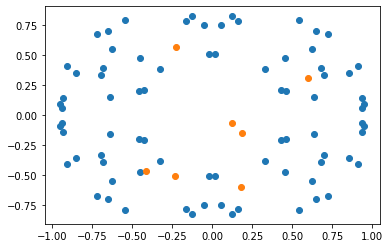

In [ ]:
plt.scatter([w_l1[:, 0], w_l1[:, 0], -1 * w_l1[:, 0], -1 * w_l1[:, 0]], [w_l1[:, 1], -1 * w_l1[:, 1], w_l1[:, 1], -1 * w_l1[:, 1]])
# plt.scatter(, )
# plt.scatter(, )
# plt.scatter(-1 * w_l1[:, 0], )
plt.scatter(w_l1_app[:, 0], w_l1_app[:, 1])

In [ ]:
import plotly.express as px
df = pd.DataFrame(w_l1_app)
df['approx'] = 'T'
df1 = pd.DataFrame(w_l1)
df1['approx'] = 'F'
df = pd.concat([df, df1])
print(df)
fig = px.scatter_3d(df, x=0, y=1, z=2, color='approx')
fig.show()

           0         1         2 approx
0  -0.354126  0.892353 -0.279823      T
1   0.331203  0.075037 -0.940571      T
2  -0.041518 -0.107463 -0.993342      T
3  -0.283567 -0.766148 -0.576720      T
4  -0.008115  0.127542 -0.991800      T
5  -0.034652  0.153135 -0.987598      T
6   0.002500  0.108993 -0.994039      T
7  -0.053155  0.000433 -0.998586      T
8  -0.085909  0.030973 -0.995821      T
9   0.020905  0.868135 -0.495888      T
0   0.909744  0.408084 -0.076378      F
1   0.452172  0.472894  0.756248      F
2  -0.163825 -0.786066 -0.596038      F
3   0.638598 -0.154808 -0.753809      F
4   0.853549 -0.354537  0.381782      F
5  -0.124184  0.823717  0.553234      F
6  -0.696186 -0.330421 -0.637296      F
7  -0.950444  0.093375 -0.296543      F
8   0.017779  0.505773 -0.862484      F
9  -0.428771 -0.209692  0.878740      F
10  0.936647  0.062263 -0.344696      F
11  0.647982 -0.700176 -0.299790      F
12 -0.679992 -0.389305  0.621332      F
13 -0.054444 -0.753405 -0.655299      F
